In [28]:
import pandas as pd 
import numpy as np
from itertools import combinations

!pip install pgmpy
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization, HillClimbSearch, MaximumLikelihoodEstimator, MmhcEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

import networkx as nx
import pylab as plb
from sklearn.metrics import f1_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_html("https://github.com/monikachudyba/MachineLearningProjects/blob/main/data/HepatitisCdata.csv")
df = df[0].drop(columns=['Unnamed: 0', 'Unnamed: 1'])
df.sample(10)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
508,0=Blood Donor,58,f,35.3,91.4,14.7,21.0,18.0,6.58,5.51,60.0,10.2,70.4
350,0=Blood Donor,35,f,46.1,88.7,23.1,20.0,7.7,8.41,4.79,74.0,28.1,79.3
523,0=Blood Donor,62,f,35.4,59.7,21.2,24.7,3.3,9.00,7.45,59.0,17.7,65.4
249,0=Blood Donor,55,m,44.7,71.6,22.9,22.1,5.5,6.82,4.61,105.0,59.2,72.7
436,0=Blood Donor,48,f,44.4,64.5,17.2,21.1,17.3,4.93,4.05,67.0,12.1,71.2
204,0=Blood Donor,50,m,39.7,96.5,54.8,30.8,3.3,8.98,5.66,82.0,52.4,65.8
268,0=Blood Donor,59,m,45.3,106.5,13.5,19.2,6.9,7.97,4.86,67.0,15.7,74.6
213,0=Blood Donor,51,m,46.3,69.4,20.1,26.8,4.5,9.99,4.14,81.0,12.3,73.9
458,0=Blood Donor,51,f,41.4,136.9,33.2,20.0,5.0,10.27,6.24,77.0,106.7,72.2
510,0=Blood Donor,58,f,47.0,74.8,36.1,28.9,5.3,9.82,6.71,70.0,32.0,76.6


In [ ]:
len(df)

615

##Dealing with non-numeric data

In [3]:
sorted(df['Sex'].unique())
df['Sex'] = df['Sex'].map({'f': 0,'m': 1})

**Target -> Hepatisis: 1, else: 0.**

In [4]:
sorted(df['Category'].unique())
df['Category'] = df['Category'].map({'0=Blood Donor': 0,'0s=suspect Blood Donor': 0,'1=Hepatitis': 1,'2=Fibrosis': 0,'3=Cirrhosis': 0})

In [ ]:
df.sample(10)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
9,0,32,1,42.4,86.3,20.3,20.0,35.2,5.46,4.45,81.0,15.9,69.9
33,0,35,1,37.5,69.8,37.1,25.0,7.8,11.66,5.73,84.0,27.3,71.0
227,0,53,1,38.7,104.0,66.9,34.3,7.8,8.07,4.60,106.0,73.7,73.2
398,0,45,0,39.5,92.2,18.7,19.4,3.5,8.32,5.38,85.0,15.8,72.2
26,0,34,1,42.6,27.0,21.4,21.7,7.2,8.15,6.79,85.0,13.9,67.7
164,0,47,1,40.8,42.8,39.0,31.7,23.5,6.44,4.86,96.0,27.8,66.4
605,0,42,0,33.0,79.0,3.7,55.7,200.0,1.72,5.16,89.1,146.3,69.9
369,0,40,0,43.2,42.4,15.7,23.6,9.7,7.56,6.74,88.0,11.5,73.2
276,0,60,1,46.3,59.7,24.4,30.4,18.0,7.05,6.20,91.0,13.8,66.9
470,0,52,0,36.7,87.6,34.3,30.8,17.7,10.12,6.98,72.0,24.2,66.3


In [ ]:
df.columns

Index(['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')

In [ ]:
df.dtypes

Category      int64
Age           int64
Sex           int64
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
dtype: object

In [5]:
df_with_nans = df

In [ ]:
#df = df_with_nans

In [6]:
df = df.dropna().reset_index(drop=True)

In [7]:
sum(df['Category'] == 1)

20

# Network for data considered as discrete variables

## Structure Learning

### Testing basic dependeces

In [ ]:
col_combination = list(combinations(df.columns, 2))

In [ ]:
#chi_square(8), cressie_read(4), 
independent = []
dependent = []
for cc in col_combination:
    if chi_square(X=cc[0], Y=cc[1], Z=[], data=df, boolean=True, significance_level=0.05):
        independent.append(cc) 

In [ ]:
independent

[('Category', 'Sex'),
 ('Category', 'ALB'),
 ('Category', 'CHE'),
 ('Category', 'CHOL'),
 ('Category', 'PROT'),
 ('Age', 'Sex'),
 ('Age', 'ALP'),
 ('Age', 'BIL'),
 ('Sex', 'ALB'),
 ('Sex', 'ALP'),
 ('Sex', 'ALT'),
 ('Sex', 'AST'),
 ('Sex', 'BIL'),
 ('Sex', 'CHE'),
 ('Sex', 'CHOL'),
 ('Sex', 'GGT'),
 ('Sex', 'PROT'),
 ('ALB', 'CHOL'),
 ('ALP', 'CHE')]

**The aim is to estimate 'Category', so features independent on 'Cathegory' are dropped for DAG calculation speed-up.**

In [ ]:
df_dep = df.drop(columns=['Sex', 'ALB', 'CHE', 'CHOL', 'PROT'])

In [ ]:
df_dep.sample(5)

,Category,Age,ALP,ALT,AST,BIL,CREA,GGT
143,0,45,64.4,18.8,27.2,5.2,74.0,19.7
132,0,44,81.7,27.5,29.5,6.4,83.0,24.1
537,0,71,69.8,19.7,95.2,9.8,9.0,7.6
574,0,59,34.5,8.9,74.5,6.0,65.0,95.3
152,0,46,51.6,19.7,21.8,6.3,84.0,20.9


In [ ]:
col_combination = list(combinations(df_dep.columns, 2))
independent = []
dependent = []
for cc in col_combination:
    if chi_square(X=cc[0], Y=cc[1], Z=[], data=df_dep, boolean=True, significance_level=0.05):
        independent.append(cc) 

In [ ]:
intdep = independent + [t[::-1] for t in independent]

In [ ]:
hcs = HillClimbSearch(df_dep)
best_model = hcs.estimate(scoring_method='k2score', max_indegree=2, black_list=intdep, max_iter=100) #start_dag=start_dag
print(best_model.edges())
del hcs 

  0%|          | 0/100 [00:00<?, ?it/s]

[('Category', 'CREA'), ('Category', 'BIL'), ('Category', 'Age'), ('Category', 'ALT'), ('Category', 'GGT'), ('ALT', 'ALP'), ('AST', 'GGT'), ('AST', 'ALT'), ('BIL', 'AST'), ('CREA', 'AST'), ('GGT', 'ALP')]


In [ ]:
del best_model
best_model = [('Category', 'CREA'), ('Category', 'BIL'), ('Category', 'Age'), ('Category', 'ALT'), ('Category', 'GGT'), ('ALT', 'ALP'), ('AST', 'GGT'), ('AST', 'ALT'), ('BIL', 'AST'), ('CREA', 'AST'), ('GGT', 'ALP')]

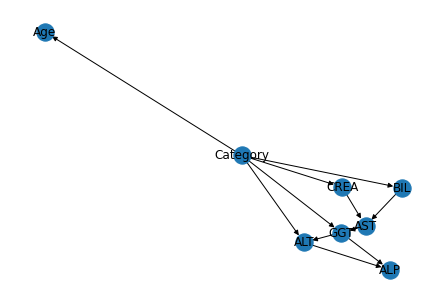

In [ ]:
nx_graph = nx.DiGraph(best_model)
nx.draw(nx_graph, with_labels=True)
plb.show()

In pgmpy it is possible to learn the CPT of a given Bayesian network using either a Bayesian Estimator or a Maximum Likelihood Estimator (MLE). The former exploits a known prior distribution of data, the latter does not make any particular assumption.

MLE can overfit the data in case of small datasets, because there can be not enough observations and thus the observed frequencies can be not representative. Another problem with MLE is the fact that state counts are done conditionally for each parents configuration and this causes immense fragmentation since the state counts drop even more. The Bayesian estimator instead does not only rely on input data to learn the network parameters, but it also takes advantage of a prior knowledge, expressed through a prior distribution. In this way, the estimator does not have an absolute guide, but rather a reasonable starting assumption that allows to counterbalance the lack of data.

Although the MLE approach seems plausible, it can be overly simplistic in many cases, whereas the Bayesian one is intrinsically more robust. 

There are several prior distribuitions available in pgmpy, a sensible choice of prior is the Bayesian Dirichlet equivalent uniform prior (BDeu). In the learning process, using BDeu, N uniform samples are generated for each variable to compute the pseudo-counts (default is N=5), hence the estimated probabilities in CPT are more conservative than the ones obtained through MLE (i.e. probabilities close to 1 or 0 get smoothed).

In [ ]:
model = BayesianNetwork(best_model)
print('\nLearning CPD using Maximum likelihood estimator')
model.fit(df_dep, estimator=MaximumLikelihoodEstimator)

print('\n Inferencing with Bayesian Network:')
model_infer = VariableElimination(model)

print('\n 1. Probability of Hepatitis given evidence = Age')
q1 = model_infer.query(variables=['Category'], evidence={'Age': 64})
print(q1)

print('\n 2. Probability of Hepatitis given evidence = CREA')
q2 = model_infer.query(variables=['Category'], evidence={'CREA': 65})
print(q2)


Learning CPD using Maximum likelihood estimator

 Inferencing with Bayesian Network:

 1. Probability of Hepatitis given evidence= Age
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          1.0000 |
+-------------+-----------------+
| Category(1) |          0.0000 |
+-------------+-----------------+

 2. Probability of Hepatitis given evidence= CREA
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          1.0000 |
+-------------+-----------------+
| Category(1) |          0.0000 |
+-------------+-----------------+


In [ ]:
model = BayesianNetwork(best_model)
print('\nLearning CPD using Bayesian estimator')
model.fit(df_dep)

print('\n Inferencing with Bayesian Network:')
model_infer = VariableElimination(model)

print('\n 1. Probability of Hepatitis given evidence = Age')
q1 = model_infer.query(variables=['Category'], evidence={'Age': 64})
print(q1)

print('\n 2. Probability of Hepatitis given evidence = CREA')
q2 = model_infer.query(variables=['Category'], evidence={'CREA': 65})
print(q2)


Learning CPD using Bayesian estimator

 Inferencing with Bayesian Network:

 1. Probability of Hepatitis given evidence = Age
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          1.0000 |
+-------------+-----------------+
| Category(1) |          0.0000 |
+-------------+-----------------+

 2. Probability of Hepatitis given evidence = CREA 
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          1.0000 |
+-------------+-----------------+
| Category(1) |          0.0000 |
+-------------+-----------------+


Predicting values from new data points
Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query.

In [ ]:
model_infer.map_query(['Category'])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Category': 0}

In [ ]:
model_infer.map_query(['Category'], evidence={'CREA': 60, 'BIL': 99})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Category': 0}

In [ ]:
test = df.sample(50, random_state=2022)
testX = test.drop(columns=['Category'])
testY = test['Category']

In [ ]:
model.predict_probability(testX)[:10]

,Category_0,Category_1
195,1.0,0.0
67,1.0,0.0
222,1.0,0.0
384,1.0,0.0
201,1.0,0.0
169,1.0,0.0
269,1.0,0.0
295,1.0,0.0
397,1.0,0.0
253,1.0,0.0


In [ ]:
pred = model.predict(testX)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print("F1-score is:", f1_score(testY, pred))

F1-score is: 1.0


In [ ]:
#model.get_cpds()

### Hybrid Structure Learning with MMHC algorithm

In [ ]:
mmhc = MmhcEstimator(df)
skeleton = mmhc.mmpc(significance_level=0.05)
print("Part 1) Skeleton: ", skeleton.edges())

Part 1) Skeleton:  [('Category', 'Sex'), ('Age', 'GGT'), ('Age', 'ALB'), ('Age', 'CHOL'), ('ALP', 'BIL'), ('ALP', 'AST'), ('BIL', 'CREA'), ('CHE', 'GGT'), ('GGT', 'PROT')]


In [ ]:
# use hill climb search to orient the edges:
hcs = HillClimbSearch(df)
best_model = hcs.estimate(scoring_method='k2score', white_list=skeleton.edges(), max_iter=100) #tabu_length=10
print("Part 2) Model:    ", best_model.edges())
del hcs 

  0%|          | 0/100 [00:00<?, ?it/s]

Part 2) Model:     [('Category', 'Sex'), ('Age', 'CHOL'), ('Age', 'ALB'), ('ALP', 'AST'), ('CHE', 'GGT'), ('GGT', 'PROT')]


In [ ]:
del best_model
best_model = [('Category', 'Sex'), ('Age', 'CHOL'), ('Age', 'ALB'), ('ALP', 'AST'), ('CHE', 'GGT'), ('GGT', 'PROT')]

In [ ]:
df.columns

Index(['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')

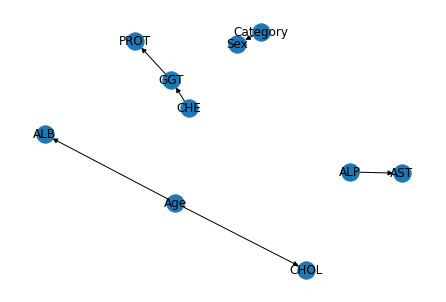

In [ ]:
nx_graph = nx.DiGraph(best_model)
nx.draw(nx_graph, with_labels=True)
plb.show()

In [ ]:
model = BayesianNetwork(best_model)
print('\nLearning CPD using Bayesian estimator')
model.fit(df)

print('\n Inferencing with Bayesian Network:')
model_infer = VariableElimination(model)

print('\n 1. Probability of Hepatitis given evidence = Age')
q1 = model_infer.query(variables=['Category'], evidence={'Age': 64})
print(q1)

print('\n 2. Probability of Hepatitis given evidence = CHOL')
q2 = model_infer.query(variables=['Category'], evidence={'CHOL': 5.73})
print(q2)


Learning CPD using Bayesian estimator

 Inferencing with Bayesian Network:

 1. Probability of Hepatitis given evidence = Age
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          0.9660 |
+-------------+-----------------+
| Category(1) |          0.0340 |
+-------------+-----------------+

 2. Probability of Hepatitis given evidence = CHOL
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          0.9660 |
+-------------+-----------------+
| Category(1) |          0.0340 |
+-------------+-----------------+


In [ ]:
model_infer.map_query(['Category'])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Category': 0}

In [ ]:
model_infer.map_query(['Category'], evidence={'Age': 60, 'Sex': 1})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Category': 0}

In [ ]:
test = df.sample(50, random_state=2022)
testX = test.drop(columns=['Category', 'CREA', 'BIL', 'ALT'])
testY = test['Category']

In [ ]:
model.predict_probability(testX)[:10]

,Category_0,Category_1
194,0.955923,0.044077
67,0.955923,0.044077
221,0.955923,0.044077
381,0.982301,0.017699
200,0.955923,0.044077
168,0.955923,0.044077
268,0.955923,0.044077
294,0.955923,0.044077
394,0.982301,0.017699
252,0.955923,0.044077


In [ ]:
pred = model.predict(testX)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print("F1-score is:", f1_score(testY, pred))

F1-score is: 0.0


In [ ]:
model.simulate()

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."


,GGT,CHOL,Sex,CHE,Category,PROT,ALB,ALP,AST,Age
0,49.8,5.20,1,10.04,0,73.1,38.5,68.3,56.2,32
1,74.5,4.43,0,7.26,0,65.4,36.3,81.5,35.3,33
2,46.0,5.47,1,6.06,0,56.9,39.9,73.1,20.8,54
3,17.2,5.50,0,4.72,0,65.6,42.1,61.4,34.8,56
4,28.5,3.61,1,4.02,0,75.0,36.0,74.3,16.8,59
5,19.1,5.56,1,7.68,0,76.9,42.0,79.3,30.8,41
6,18.9,4.27,0,8.26,0,74.0,46.0,66.5,29.1,48
7,29.9,5.42,0,15.40,0,77.8,41.0,116.9,24.3,57
8,28.5,6.27,1,2.47,0,62.3,36.7,89.4,24.1,45
9,24.1,8.80,1,8.81,0,72.8,42.0,87.3,99.0,50


**Model always predicts 'Category' = 0.**

# Network for data with discretization

In [74]:
TIERS_NUM = 5


def get_boundaries(data):
    step = (max(data) + 0.2 - min(data))/TIERS_NUM #wider range +-0.1 against rounding errors
    boundaries = [(min(data) - 0.1, min(data) - 0.1 + step)]
    less = min(data) + step - 0.1
    for index in range(TIERS_NUM):
        if index is not 0:
            boundaries.append((less, less + step))
            less += step
    return boundaries


def relabel(v, boundaries):
  for i in range(TIERS_NUM):
    if v >= boundaries[i][0] and v < boundaries[i][1]:
      return boundary_str(boundaries[i][0], boundaries[i][1], tier=i)
    else:
        continue


def boundary_str(start, end, tier):
    return f'{tier}: ({start:0,.2f}, {end:0,.2f})'


def lookup(evidence, boundaries):
  dicts = {}
  for k, v in evidence.items():
    if k in bounds.keys():
      dicts[k] = relabel(v, boundaries[k])
  return dicts

In [75]:
new_columns = {}
bounds = {}
df_X = df.drop(columns=['Category', 'Sex'])
for i, content in enumerate(df_X.items()):
    (label, series) = content
    boundaries = get_boundaries(series)
    bounds[label] = boundaries
    new_columns[label] = [relabel(value, boundaries) for value in series.tolist()]

df_temp = pd.DataFrame(data=new_columns)
df_discr = pd.concat([df_temp, df[['Sex', 'Category']]], axis=1)
df_discr.iloc[313:315]

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex,Category
313,"4: (66.26, 77.10)","1: (28.30, 41.80)","0: (11.20, 92.30)","0: (0.80, 65.72)","0: (10.50, 73.22)","0: (0.70, 42.38)","2: (7.40, 10.43)","2: (4.71, 6.39)","0: (7.90, 222.16)","0: (4.40, 133.72)","2: (61.46, 69.84)",1,0
314,"4: (66.26, 77.10)","1: (28.30, 41.80)","0: (11.20, 92.30)","0: (0.80, 65.72)","0: (10.50, 73.22)","0: (0.70, 42.38)","1: (4.36, 7.40)","0: (1.33, 3.02)","0: (7.90, 222.16)","0: (4.40, 133.72)","1: (53.08, 61.46)",1,0


In [76]:
df.iloc[313:315]

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
313,0,71,1,39.0,87.9,26.1,32.1,12.2,10.30,6.31,90.0,99.7,69.8
314,0,76,1,29.2,48.9,25.2,27.2,8.3,4.52,2.79,127.0,18.3,58.1


In [ ]:
col_combination = list(combinations(df_discr.columns, 2))

In [ ]:
#chi_square(8), cressie_read(4), 
independent = []
dependent = []
for cc in col_combination:
    if chi_square(X=cc[0], Y=cc[1], Z=[], data=df_discr, boolean=True, significance_level=0.05):
        independent.append(cc) 

In [ ]:
independent

[('Age', 'ALP'),
 ('Age', 'ALT'),
 ('Age', 'BIL'),
 ('Age', 'CREA'),
 ('Age', 'Sex'),
 ('ALB', 'Category'),
 ('ALP', 'Sex'),
 ('ALT', 'BIL'),
 ('ALT', 'Category'),
 ('BIL', 'CREA'),
 ('CHOL', 'CREA'),
 ('CHOL', 'Sex'),
 ('CREA', 'Category'),
 ('PROT', 'Sex'),
 ('PROT', 'Category'),
 ('Sex', 'Category')]

In [ ]:
intdep = independent + [t[::-1] for t in independent]

In [ ]:
hcs = HillClimbSearch(df_discr)
best_model = hcs.estimate(scoring_method='k2score', black_list=intdep, max_iter=100) #start_dag=start_dag
print(best_model.edges())
del hcs 

  0%|          | 0/100 [00:00<?, ?it/s]

[('ALB', 'PROT'), ('ALT', 'Sex'), ('AST', 'ALT'), ('AST', 'Sex'), ('AST', 'Category'), ('AST', 'CHE'), ('CREA', 'Sex'), ('GGT', 'AST'), ('Category', 'ALP'), ('Category', 'Age')]


In [ ]:
best_model = best_model.edges()

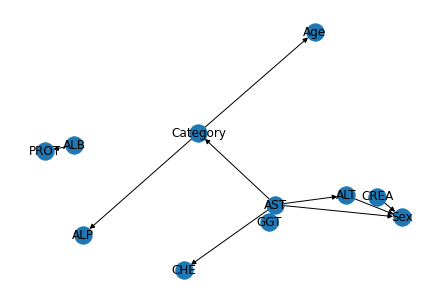

In [ ]:
nx_graph = nx.DiGraph(best_model)
nx.draw(nx_graph, with_labels=True)
plb.show()

In [ ]:
model = BayesianNetwork(best_model)
print('\nLearning CPD using Bayesian estimator')
model.fit(df_discr)

print('\n Inferencing with Bayesian Network:')
model_infer = VariableElimination(model)

print('\n 1. Probability of Hepatitis given evidence = Age')
q1 = model_infer.query(variables=['Category'], evidence=lookup({'Age': 65}, bounds))
print(q1)

print('\n 2. Probability of Hepatitis given evidence = CREA')
q2 = model_infer.query(variables=['Category'], evidence=lookup({'CREA': 100}, bounds))
print(q2)


Learning CPD using Bayesian estimator

 Inferencing with Bayesian Network:

 1. Probability of Hepatitis given evidence = Age
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          1.0000 |
+-------------+-----------------+
| Category(1) |          0.0000 |
+-------------+-----------------+

 2. Probability of Hepatitis given evidence = CREA
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          0.9660 |
+-------------+-----------------+
| Category(1) |          0.0340 |
+-------------+-----------------+


In [ ]:
model_infer.map_query(['Category'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'Category': 0}

In [ ]:
model_infer.map_query(['Category'], evidence=lookup({'CREA': 100, 'CHE': 2.5}, bounds))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'Category': 0}

In [ ]:
test = df_discr.sample(50, random_state=2022)
testX = test.drop(columns=['Category', 'BIL', 'CHOL'])
testY = test['Category']

In [ ]:
model.predict_probability(testX)[:10]

,Category_0,Category_1
194,0.999630,0.000370
67,1.000000,0.000000
221,0.999739,0.000261
381,1.000000,0.000000
200,0.995909,0.004091
168,0.999826,0.000174
268,1.000000,0.000000
294,1.000000,0.000000
394,0.999826,0.000174
252,0.987758,0.012242


In [ ]:
pred = model.predict(testX)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print("F1-score is:", f1_score(testY, pred))

F1-score is: 1.0


In [ ]:
model.simulate()

  0%|          | 0/13 [00:00<?, ?it/s]

,GGT,CREA,CHOL,Sex,CHE,PROT,Category,BIL,ALB,ALT,ALP,AST,Age
0,"1: (69.06, 133.72)","0: (7.90, 115.03)","3: (3.86, 4.71)",0,"3: (5.88, 7.40)","6: (69.84, 74.03)",0,"0: (0.70, 21.54)","4: (41.80, 48.55)","0: (0.80, 33.26)","1: (51.75, 92.30)","0: (10.50, 41.86)","4: (44.58, 50.00)"
1,"0: (4.40, 69.06)","0: (7.90, 115.03)","4: (4.71, 5.55)",0,"4: (7.40, 8.91)","6: (69.84, 74.03)",0,"0: (0.70, 21.54)","4: (41.80, 48.55)","0: (0.80, 33.26)","3: (132.85, 173.40)","0: (10.50, 41.86)","2: (33.74, 39.16)"
2,"1: (69.06, 133.72)","0: (7.90, 115.03)","5: (5.55, 6.39)",1,"1: (2.84, 4.36)","9: (82.41, 86.60)",0,"0: (0.70, 21.54)","4: (41.80, 48.55)","0: (0.80, 33.26)","1: (51.75, 92.30)","0: (10.50, 41.86)","7: (60.84, 66.26)"
3,"0: (4.40, 69.06)","0: (7.90, 115.03)","7: (7.24, 8.08)",1,"5: (8.91, 10.43)","5: (65.65, 69.84)",0,"0: (0.70, 21.54)","3: (35.05, 41.80)","1: (33.26, 65.72)","1: (51.75, 92.30)","0: (10.50, 41.86)","2: (33.74, 39.16)"
4,"0: (4.40, 69.06)","0: (7.90, 115.03)","5: (5.55, 6.39)",1,"4: (7.40, 8.91)","5: (65.65, 69.84)",0,"0: (0.70, 21.54)","3: (35.05, 41.80)","1: (33.26, 65.72)","1: (51.75, 92.30)","0: (10.50, 41.86)","2: (33.74, 39.16)"
5,"0: (4.40, 69.06)","0: (7.90, 115.03)","2: (3.02, 3.86)",0,"3: (5.88, 7.40)","6: (69.84, 74.03)",0,"0: (0.70, 21.54)","4: (41.80, 48.55)","0: (0.80, 33.26)","0: (11.20, 51.75)","0: (10.50, 41.86)","7: (60.84, 66.26)"
6,"0: (4.40, 69.06)","0: (7.90, 115.03)","4: (4.71, 5.55)",1,"6: (10.43, 11.95)","7: (74.03, 78.22)",0,"0: (0.70, 21.54)","4: (41.80, 48.55)","0: (0.80, 33.26)","1: (51.75, 92.30)","0: (10.50, 41.86)","5: (50.00, 55.42)"
7,"0: (4.40, 69.06)","0: (7.90, 115.03)","5: (5.55, 6.39)",1,"5: (8.91, 10.43)","7: (74.03, 78.22)",0,"0: (0.70, 21.54)","3: (35.05, 41.80)","0: (0.80, 33.26)","2: (92.30, 132.85)","0: (10.50, 41.86)","1: (28.32, 33.74)"
8,"0: (4.40, 69.06)","0: (7.90, 115.03)","4: (4.71, 5.55)",0,"7: (11.95, 13.47)","5: (65.65, 69.84)",0,"0: (0.70, 21.54)","3: (35.05, 41.80)","0: (0.80, 33.26)","1: (51.75, 92.30)","0: (10.50, 41.86)","3: (39.16, 44.58)"
9,"0: (4.40, 69.06)","0: (7.90, 115.03)","5: (5.55, 6.39)",0,"5: (8.91, 10.43)","6: (69.84, 74.03)",0,"0: (0.70, 21.54)","3: (35.05, 41.80)","0: (0.80, 33.26)","1: (51.75, 92.30)","0: (10.50, 41.86)","8: (66.26, 71.68)"


### Hybrid Structure Learning with MMHC algorithm

In [77]:
mmhc = MmhcEstimator(df_discr)
skeleton = mmhc.mmpc(significance_level=0.05)
print("Part 1) Skeleton: ", skeleton.edges())

Part 1) Skeleton:  [('Age', 'CHE'), ('Age', 'ALT'), ('Age', 'CHOL'), ('ALB', 'PROT'), ('ALB', 'AST'), ('ALB', 'ALP'), ('ALB', 'Category'), ('ALP', 'CHE'), ('ALP', 'PROT'), ('ALT', 'CHE'), ('ALT', 'PROT'), ('ALT', 'AST'), ('AST', 'CHE'), ('AST', 'CHOL'), ('BIL', 'CHE'), ('BIL', 'PROT'), ('BIL', 'CHOL'), ('CHE', 'Sex'), ('CHE', 'CREA'), ('CHOL', 'GGT'), ('CHOL', 'Category'), ('GGT', 'Category'), ('PROT', 'Sex')]


In [ ]:
#[('Age', 'CHE'), ('Age', 'ALT'), ('Age', 'CHOL'), ('ALB', 'PROT'), ('ALB', 'AST'), ('ALB', 'ALP'), ('ALB', 'Category'), ('ALP', 'CHE'), ('ALP', 'PROT'), ('ALT', 'CHE'), ('ALT', 'PROT'), ('ALT', 'AST'), ('AST', 'CHE'), ('AST', 'CHOL'), ('BIL', 'CHE'), ('BIL', 'PROT'), ('BIL', 'CHOL'), ('CHE', 'Sex'), ('CHE', 'CREA'), ('CHOL', 'GGT'), ('CHOL', 'Category'), ('GGT', 'Category'), ('PROT', 'Sex')]

In [78]:
# use hill climb search to orient the edges:
hcs = HillClimbSearch(df_discr)
best_model = hcs.estimate(scoring_method='k2score', white_list=skeleton.edges(), max_iter=100) #tabu_length=10
print("Part 2) Model:    ", best_model.edges())
del hcs 

  0%|          | 0/100 [00:00<?, ?it/s]

Part 2) Model:     [('ALB', 'PROT'), ('ALT', 'AST'), ('AST', 'CHOL'), ('AST', 'CHE'), ('BIL', 'CHE'), ('CHE', 'Sex'), ('GGT', 'Category')]


In [79]:
best_model = [('ALB', 'PROT'), ('ALT', 'AST'), ('AST', 'CHOL'), ('AST', 'CHE'), ('BIL', 'CHE'), ('CHE', 'Sex'), ('GGT', 'Category')]

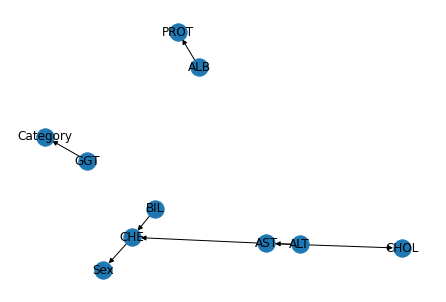

In [82]:
nx_graph = nx.DiGraph(best_model)
nx.draw(nx_graph, with_labels=True)
plb.show()

In [83]:
model = BayesianNetwork(best_model)
print('\nLearning CPD using Bayesian estimator')
model.fit(df_discr)

print('\n Inferencing with Bayesian Network:')
model_infer = VariableElimination(model)

print('\n 1. Probability of Hepatitis given evidence = AST')
q1 = model_infer.query(variables=['Category'], evidence=lookup({'AST': 15}, bounds))
print(q1)

print('\n 2. Probability of Hepatitis given evidence = GTT')
q2 = model_infer.query(variables=['Category'], evidence=lookup({'GTT': 100}, bounds))
print(q2)


Learning CPD using Bayesian estimator

 Inferencing with Bayesian Network:

 1. Probability of Hepatitis given evidence = AST
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          0.9660 |
+-------------+-----------------+
| Category(1) |          0.0340 |
+-------------+-----------------+

 2. Probability of Hepatitis given evidence = GTT
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          0.9660 |
+-------------+-----------------+
| Category(1) |          0.0340 |
+-------------+-----------------+


In [84]:
model_infer.map_query(['Category'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'Category': 0}

In [87]:
model_infer.map_query(['Category'], evidence=lookup({'BIL': 25, 'CHE': 2.5}, bounds))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'Category': 0}

In [88]:
diff = set(df.columns) - set(model.nodes())
diff

{'ALP', 'Age', 'CREA'}

In [89]:
test = df_discr.sample(50, random_state=2022)
testX = test.drop(columns=['Category', 'ALP', 'Age', 'CREA'])
testY = test['Category']

In [90]:
model.predict_probability(testX)[:10]

,Category_0,Category_1
194,0.973638,0.026362
67,0.973638,0.026362
221,0.973638,0.026362
381,0.973638,0.026362
200,0.973638,0.026362
168,0.973638,0.026362
268,0.973638,0.026362
294,0.973638,0.026362
394,0.973638,0.026362
252,0.973638,0.026362


In [91]:
pred = model.predict(testX)

  0%|          | 0/36 [00:00<?, ?it/s]

In [92]:
print("F1-score is:", f1_score(testY, pred))

F1-score is: 0.0


In [93]:
model.simulate()

  0%|          | 0/10 [00:00<?, ?it/s]

,AST,Category,CHE,ALB,BIL,PROT,CHOL,GGT,ALT,Sex
0,"0: (10.50, 73.22)",0,"2: (7.40, 10.43)","2: (41.80, 55.30)","0: (0.70, 42.38)","2: (61.46, 69.84)","1: (3.02, 4.71)","0: (4.40, 133.72)","0: (0.80, 65.72)",0
1,"0: (10.50, 73.22)",0,"1: (4.36, 7.40)","1: (28.30, 41.80)","0: (0.70, 42.38)","3: (69.84, 78.22)","4: (8.08, 9.77)","0: (4.40, 133.72)","0: (0.80, 65.72)",0
2,"0: (10.50, 73.22)",0,"1: (4.36, 7.40)","1: (28.30, 41.80)","0: (0.70, 42.38)","3: (69.84, 78.22)","1: (3.02, 4.71)","0: (4.40, 133.72)","0: (0.80, 65.72)",1
3,"0: (10.50, 73.22)",0,"3: (10.43, 13.47)","1: (28.30, 41.80)","0: (0.70, 42.38)","3: (69.84, 78.22)","1: (3.02, 4.71)","0: (4.40, 133.72)","0: (0.80, 65.72)",0
4,"0: (10.50, 73.22)",0,"1: (4.36, 7.40)","2: (41.80, 55.30)","0: (0.70, 42.38)","3: (69.84, 78.22)","2: (4.71, 6.39)","0: (4.40, 133.72)","0: (0.80, 65.72)",1
5,"0: (10.50, 73.22)",0,"1: (4.36, 7.40)","1: (28.30, 41.80)","0: (0.70, 42.38)","3: (69.84, 78.22)","1: (3.02, 4.71)","0: (4.40, 133.72)","1: (65.72, 130.64)",1
6,"0: (10.50, 73.22)",0,"2: (7.40, 10.43)","2: (41.80, 55.30)","0: (0.70, 42.38)","3: (69.84, 78.22)","3: (6.39, 8.08)","0: (4.40, 133.72)","0: (0.80, 65.72)",1
7,"0: (10.50, 73.22)",0,"3: (10.43, 13.47)","2: (41.80, 55.30)","0: (0.70, 42.38)","2: (61.46, 69.84)","1: (3.02, 4.71)","0: (4.40, 133.72)","0: (0.80, 65.72)",1
8,"0: (10.50, 73.22)",0,"0: (1.32, 4.36)","2: (41.80, 55.30)","4: (167.42, 209.10)","2: (61.46, 69.84)","4: (8.08, 9.77)","0: (4.40, 133.72)","0: (0.80, 65.72)",0
9,"1: (73.22, 135.94)",0,"2: (7.40, 10.43)","1: (28.30, 41.80)","0: (0.70, 42.38)","3: (69.84, 78.22)","1: (3.02, 4.71)","0: (4.40, 133.72)","0: (0.80, 65.72)",1


# NaNs filling

In [29]:
best_model = [('Category', 'CREA'), ('Category', 'BIL'), ('Category', 'Age'), ('Category', 'ALT'), ('Category', 'GGT'), ('ALT', 'ALP'), ('AST', 'GGT'), ('AST', 'ALT'), ('BIL', 'AST'), ('CREA', 'AST'), ('GGT', 'ALP')]

In [52]:
modelNA = BayesianNetwork(best_model)
modelNA.fit(df_with_nans, estimator=BayesianEstimator, 
            prior_type="BDeu", equivalent_sample_size=1000)

In [10]:
diff = set(df_with_nans.columns) - set(modelNA.nodes())
diff

{'ALB', 'CHE', 'CHOL', 'PROT', 'Sex'}

In [48]:
data_to_fill = df_with_nans[df_with_nans.drop(columns=diff).isna().any(axis=1)].drop(columns=diff)

In [49]:
data_to_fill

,Category,Age,ALP,ALT,AST,BIL,CREA,GGT
540,1,38,56.3,NaN,33.1,7.0,77.9,18.9
541,1,19,NaN,87.0,67.0,12.0,62.0,65.0
545,1,29,NaN,53.0,39.0,15.0,79.0,37.0
546,1,30,NaN,66.0,45.0,14.0,86.0,43.0
568,0,49,NaN,118.0,62.0,10.0,72.0,74.0
569,0,49,NaN,114.0,75.0,16.0,72.0,59.0
570,0,50,NaN,258.0,106.0,15.0,77.0,80.0
571,0,53,NaN,34.0,43.0,14.0,112.0,203.0
576,0,71,NaN,130.0,90.0,15.0,79.0,77.0
581,0,49,NaN,46.0,39.0,9.0,89.0,53.0


In [50]:
def predict_na(data, model):
  for i in range(len(data)):
    row = data.iloc[i]
    col = row.isna().keys()[np.where(row.isna().values==True)[0][0]]
    data[col].iloc[i] = model.predict(pd.DataFrame(row.dropna()).transpose()).iloc[0]
  return data

In [53]:
filled = predict_na(data_to_fill, modelNA)

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
filled

,Category,Age,ALP,ALT,AST,BIL,CREA,GGT
540,1,38,56.3,0.9,33.1,7.0,77.9,18.9
541,1,19,11.3,87.0,67.0,12.0,62.0,65.0
545,1,29,11.3,53.0,39.0,15.0,79.0,37.0
546,1,30,11.3,66.0,45.0,14.0,86.0,43.0
568,0,49,11.3,118.0,62.0,10.0,72.0,74.0
569,0,49,11.3,114.0,75.0,16.0,72.0,59.0
570,0,50,11.3,258.0,106.0,15.0,77.0,80.0
571,0,53,11.3,34.0,43.0,14.0,112.0,203.0
576,0,71,11.3,130.0,90.0,15.0,79.0,77.0
581,0,49,11.3,46.0,39.0,9.0,89.0,53.0


# Expectation Maximization algorithm 

In [54]:
best_model = [('Category', 'CREA'), ('Category', 'BIL'), ('Category', 'Age'), ('Category', 'ALT'), ('Category', 'GGT'), ('ALT', 'ALP'), ('AST', 'GGT'), ('AST', 'ALT'), ('BIL', 'AST'), ('CREA', 'AST'), ('GGT', 'ALP')]

In [55]:
modelEM =  BayesianNetwork(best_model, latents=['ALP', 'ALT'])
modelEM.fit(df.drop(columns=['ALP', 'ALT']), estimator=ExpectationMaximization)

  0%|          | 0/100 [00:00<?, ?it/s]

In [56]:
diff = set(df.columns) - set(modelEM.nodes())
diff

{'ALB', 'CHE', 'CHOL', 'PROT', 'Sex'}

In [58]:
test_lat = df.drop(columns=diff).sample(50, random_state=2022)
testX_lat = test.drop(columns=['ALP', 'ALT'])

In [61]:
model.predict_probability(testX_lat)[:10].transpose()[350:360]

,194,67,221,381,200,168,268,294,394,252
ALP_29.6,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102
ALP_29.7,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102
ALP_30.7,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102
ALP_31.2,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102
ALP_31.3,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102
ALP_32.4,0.001896,0.001518,0.001992,0.001899,0.001755,0.002849,0.002053,0.00199,0.001988,0.002102
ALP_32.7,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102
ALP_32.9,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102
ALP_34.1,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102
ALP_34.4,0.001896,0.001518,0.001992,0.001899,0.001755,0.001988,0.002053,0.00199,0.001988,0.002102


In [71]:
test = df.drop(columns=diff).sample(50, random_state=2022)
testX = test.drop(columns=['Category'])
testY = test['Category']

In [72]:
pred = model.predict(testX)

  0%|          | 0/50 [00:00<?, ?it/s]

In [73]:
print("F1-score is:", f1_score(testY, pred))

F1-score is: 1.0
